In [3]:
import torch
import sys
sys.path.append('../src')

from predict import load_model, get_transform, predict_image
import matplotlib.pyplot as plt
from PIL import Image

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = load_model("../models/resnet18_best.pth", device=device)
transform = get_transform()


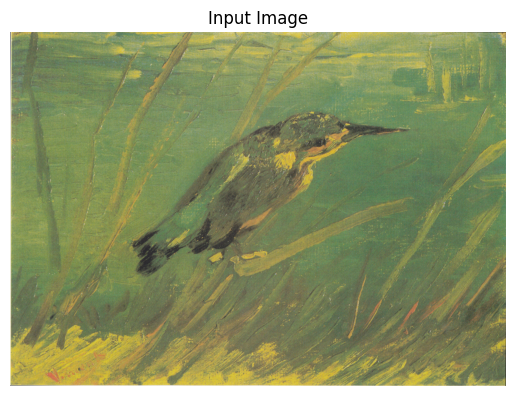

In [4]:
image_path = "../data/raw/vgdb_2016/check/9414428.png"
img = Image.open(image_path).convert("RGB")

plt.imshow(img)
plt.title("Input Image")
plt.axis('off')
plt.show()


In [5]:
label, confidence = predict_image(model, image_path, transform, device=device)
print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")


Prediction: Van Gogh 🎨 (56.26% confidence)


In [11]:
label, confidence = predict_image(model, "../data/raw/vgdb_2016/check/dog.912.jpg" ,  transform, device= device)
print(f"Prediction: {label} ({confidence*100:.2f}% confidence)")


Prediction: Van Gogh 🎨 (57.92% confidence)


In [10]:
# ✅ Cell 1: Imports and Setup
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append('../src')

from preprocessing_patches import patchify_image
from trainer import get_model  # efficientnet model loader

In [11]:
# ✅ Cell 2: Load Saved Model
model = get_model("efficientnet")
model.load_state_dict(torch.load('../models/efficientnet_best_patch.pth', map_location='cpu'))
model.eval();

In [13]:
# ✅ Cell 3: Define Transform (should match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [14]:
# ✅ Cell 4: Patch-Based Prediction Function
def predict_from_patches(image_path, model, transform, device='cpu'):
    image = Image.open(image_path).convert('RGB')
    patches = patchify_image(image, 224)
    patch_preds = []

    for patch in patches:
        input_tensor = transform(patch).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            pred = torch.argmax(output, dim=1).item()
            patch_preds.append(pred)

    # 🧠 Majority Vote
    final_pred = 1 if patch_preds.count(1) > patch_preds.count(0) else 0
    confidence = patch_preds.count(final_pred) / len(patch_preds)
    return final_pred, confidence, image, patches, patch_preds

In [15]:
# ✅ Cell 5: Run on a Sample Image
image_path = "../data/raw/vgdb_2016/check/dog.912.jpg"
label, conf, original_img, all_patches, patch_preds = predict_from_patches(image_path, model, transform)

In [16]:
# ✅ Cell 6: Show Results
print("\n🖼️ Prediction Results")
print("Predicted Label:", "Van Gogh" if label == 1 else "Not Van Gogh")
print(f"Confidence: {conf * 100:.2f}%")


🖼️ Prediction Results
Predicted Label: Not Van Gogh
Confidence: 100.00%


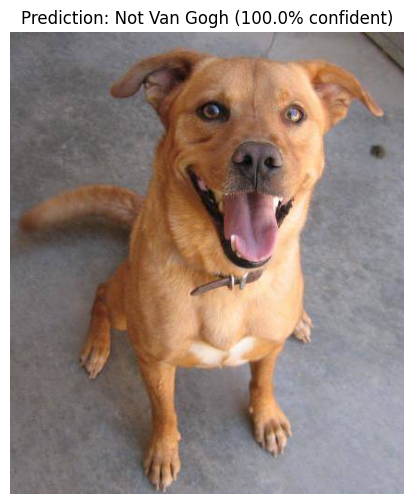

In [17]:
# ✅ Cell 7: Visual Debug (Optional)
plt.figure(figsize=(6, 6))
plt.imshow(original_img)
plt.title(f"Prediction: {'Van Gogh' if label == 1 else 'Not Van Gogh'} ({conf*100:.1f}% confident)")
plt.axis('off')
plt.show()

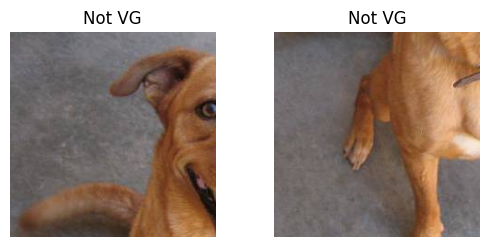

In [18]:
# ✅ Cell 8: Optional - Visualize Patch Predictions
def visualize_patch_preds(patches, preds):
    cols = 6
    rows = len(patches) // cols + 1
    plt.figure(figsize=(16, rows * 2.5))
    for i, (p, pred) in enumerate(zip(patches, preds)):
        plt.subplot(rows, cols, i+1)
        plt.imshow(p)
        plt.title("VG" if pred == 1 else "Not VG")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

visualize_patch_preds(all_patches, patch_preds)